In [55]:
import numpy as np
import tensorflow as tf
from tensorflow import keras, profiler
import time
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [56]:
def create_LeNet(image_size = (28, 28)):
    model = tf.keras.Sequential([
        # tf.keras.layers.Rescaling(1./255),
        keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, input_shape = image_size, activation="relu"), 
        keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        keras.layers.Conv2D(16, 5, 1, activation='relu'),
        keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        keras.layers.Flatten(),
        keras.layers.Dense(120, activation='relu'), # param increase here
        keras.layers.Dense(84, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [61]:
# This function consider synchronous execution and GPU aspects to measure time more accurately

def profile_inf_time(img_expanded, model):
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    repetitions = 300
    timings=np.zeros((repetitions,1))
    #GPU-WARM-UP
    for _ in range(10):
        _ = model.predict(img_expanded)
    # MEASURE PERFORMANCE
    for rep in range(repetitions):
        starter.record()
        _ = model.predict(img_expanded)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time
    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    time.sleep(1) # to avoid interference between each execution
    return mean_syn

In [62]:
img_size_list = []
n_params_list = []
infer_time_list = []

for i in range(1,16):
    # dummy image
    img_shape = (32*i, 32*i, 3)
    img = np.random.randint(0, 255, img_shape)
    img_expanded = np.expand_dims(img, axis=0)
    # built-in model - doesn't change no. of parameters with image shape 
    # processed_img = tf.keras.applications.vgg16.preprocess_input(img_expanded) 
    # model = tf.keras.applications.VGG16(input_shape = img_shape, classes=10, include_top=False, weights=None)
    # custom model
    model = create_LeNet(img_shape)
    curr_time = profile_inf_time(img_expanded, model)
    # get model stats
    n_params = model.count_params()
    print(f"Image shape:{img_shape[0]}, No. of params:{n_params}, Inference time:{curr_time}")
    # append to list
    img_size_list.append(img_shape[0])
    n_params_list.append(n_params)
    infer_time_list.append(curr_time)

Image shape:32, No. of params:62006, Inference time:53.192861760457355
Image shape:64, No. of params:338486, Inference time:55.008311398824056
Image shape:96, No. of params:860726, Inference time:54.231912218729654
Image shape:128, No. of params:1628726, Inference time:57.490130767822265
Image shape:160, No. of params:2642486, Inference time:55.63488740285238
Image shape:192, No. of params:3902006, Inference time:55.48487214406332
Image shape:224, No. of params:5407286, Inference time:56.71865041097005
Image shape:256, No. of params:7158326, Inference time:56.958253122965495
Image shape:288, No. of params:9155126, Inference time:56.69167215983073
Image shape:320, No. of params:11397686, Inference time:58.63390240987142
Image shape:352, No. of params:13886006, Inference time:62.64535302480062
Image shape:384, No. of params:16620086, Inference time:64.5068664932251
Image shape:416, No. of params:19599926, Inference time:66.19555327097575
Image shape:448, No. of params:22825526, Inference

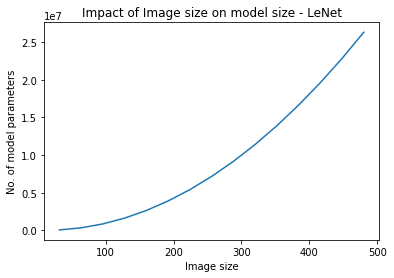

In [63]:
plt.plot(img_size_list, n_params_list)
plt.xlabel("Image size")
plt.ylabel("No. of model parameters")
plt.title("Impact of Image size on model size - LeNet")
plt.show()

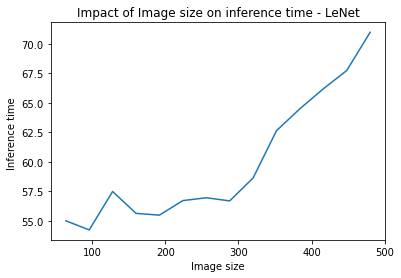

In [64]:
plt.plot(img_size_list[1:], infer_time_list[1:])
plt.xlabel("Image size")
plt.ylabel("Inference time ")
plt.title("Impact of Image size on inference time - LeNet")
plt.show()

### Investigating the impact layer

In [40]:
i=1
img_shape = (32*i, 32*i, 3)
model = create_LeNet(img_shape)
model.summary()

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 14, 14, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_97 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_97 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 flatten_66 (Flatten)        (None, 400)               0         
                                                                 
 dense_216 (Dense)           (None, 120)             

In [41]:
i=4
img_shape = (32*i, 32*i, 3)
model = create_LeNet(img_shape)
model.summary()

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 124, 124, 6)       456       
                                                                 
 max_pooling2d_98 (MaxPoolin  (None, 62, 62, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_99 (Conv2D)          (None, 58, 58, 16)        2416      
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 29, 29, 16)       0         
 g2D)                                                            
                                                                 
 flatten_67 (Flatten)        (None, 13456)             0         
                                                                 
 dense_219 (Dense)           (None, 120)             